Running MC Exploring Starts...


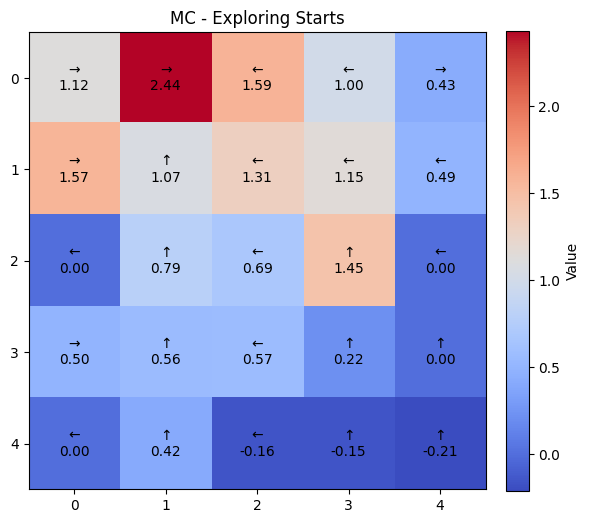

In [23]:
import numpy as np
import random
import matplotlib.pyplot as plt

# === Environment Settings ===
grid_size = 5 # Size of the grid world (5x5)
gamma = 0.95  # Discount factor
MAX_STEPS = 100 # Maximum steps allowed per episode
terminal_states = [(2, 0), (2, 4), (4, 0)] # Predefined terminal states
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # Up, Down, Left, Right
action_to_idx = {a: i for i, a in enumerate(actions)} # Create a mapping from action tuple to index

# Define special portal states
def step(state, action):
    blue = (0, 1)
    green = (0, 4)
    red = (4, 2)
    yellow = (4, 4)

    if state in terminal_states:
        return state, 0, True   # Terminal state: no change, reward 0, done = True
    if state == blue:
        return red, 5, False    # Blue portal: teleport to red with +5 reward
    if state == green:            # Green portal: random teleport to red or yellow with +2.5 reward
        next_state = random.choice([red, yellow])
        return next_state, 2.5, False
    # Normal move
    r, c = state
    dr, dc = action
    nr, nc = r + dr, c + dc
    if not (0 <= nr < grid_size and 0 <= nc < grid_size):  # If move goes out of bounds: stay, small penalty
        return state, -0.5, False

    next_state = (nr, nc)
    if next_state in terminal_states:  # If landed on terminal: return it, reward 0, done = True
        return next_state, 0, True

    return next_state, -0.2, False   # Regular step with small penalty

# === MC Exploring Starts ===
def mc_exploring_starts(num_episodes=5000):
    Q = np.zeros((grid_size, grid_size, len(actions)))  # Initialize Q-values (state, action) and policy
    Returns = [[[] for _ in range(len(actions))] for _ in range(grid_size * grid_size)]  # Track returns for each (state, action) pair
    policy = np.ones((grid_size, grid_size, len(actions))) / len(actions)

    for ep in range(num_episodes):
        # Avoid terminal start
        while True:
            s = (random.randrange(grid_size), random.randrange(grid_size))
            if s not in terminal_states:
                break
        a = actions[random.randrange(len(actions))]
        episode = [] #Generate an episode
        state, action = s, a
        done, t = False, 0
        while not done and t < MAX_STEPS:
            ns, r, done = step(state, action)
            episode.append((state, action, r))
            state = ns
            if done:
                break
            action = actions[np.argmax(policy[state[0], state[1]])]  # Choose next action greedily using current policy
            t += 1

        G = 0  # Update Q using first-visit MC
        visited = set()
        for st, ac, rew in reversed(episode):
            G = gamma * G + rew
            idx = st[0]*grid_size + st[1]  # Flattened state index
            ai = action_to_idx[ac]
            if (st, ai) not in visited:
                Returns[idx][ai].append(G)
                Q[st[0], st[1], ai] = np.mean(Returns[idx][ai])
                visited.add((st, ai))

        for r in range(grid_size):
            for c in range(grid_size):
                best_a = np.flatnonzero(Q[r, c] == Q[r, c].max())
                policy[r, c] = np.zeros(len(actions))
                policy[r, c][random.choice(best_a)] = 1.0

    print(f"Value at (0,0): {np.max(Q[0,0]):.3f}")
    print(f"Value at (0,1) [Blue]: {np.max(Q[0,1]):.3f}")
    return policy, Q

# === Visualization ===
def plot_policy_and_values(policy, Q, title=""):
    arrows = ['↑', '↓', '←', '→']
    V = np.max(Q, axis=2)  # State-value function from Q

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(V, cmap='coolwarm', interpolation='nearest')

    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xticklabels([str(i) for i in range(grid_size)])
    ax.set_yticklabels([str(i) for i in range(grid_size)])

    for i in range(grid_size):
        for j in range(grid_size):
            best_action = np.argmax(policy[i, j])
            arrow = arrows[best_action]
            value = f"{V[i, j]:.2f}"
            ax.text(j, i, f"{arrow}\n{value}", ha='center', va='center', color='black', fontsize=10)

    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Value')
    plt.grid(False)
    plt.tight_layout()
    plt.show()


# === Run All ===
print("Running MC Exploring Starts...")

plot_policy_and_values(policy_es, Q_es, "MC - Exploring Starts")



Running MC ε-Soft...


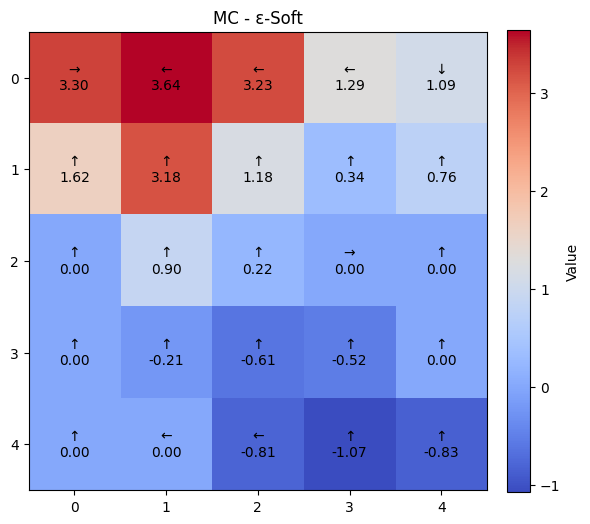

In [24]:
import numpy as np
import random
import matplotlib.pyplot as plt

# === Environment Settings ===
grid_size = 5  # Size of the grid world (5x5)
gamma = 0.95   # Discount factor
epsilon = 0.9
MAX_STEPS = 100 # Maximum steps allowed per episode
terminal_states = [(2, 0), (2, 4), (4, 0)] # Predefined terminal states
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)] #actions: Up, Down, Left, Right
action_to_idx = {a: i for i, a in enumerate(actions)}
# Define special states
def step(state, action):
    blue = (0, 1)
    green = (0, 4)
    red = (4, 2)
    yellow = (4, 4)

    # Terminal state: no change, reward 0, done = True
    if state in terminal_states:
        return state, 0, True
    if state == blue: # Blue : teleport to red with +5 reward
        return red, 5, False
    if state == green:  # Green : random teleport to red or yellow with +2.5 reward
        next_state = random.choice([red, yellow])
        return next_state, 2.5, False
     # Normal move
    r, c = state
    dr, dc = action
    nr, nc = r + dr, c + dc
    # If move goes out of bounds: stay, small penalty
    if not (0 <= nr < grid_size and 0 <= nc < grid_size):
        return state, -0.5, False

    next_state = (nr, nc)
    # If landed on terminal: return it, reward 0, done = True
    if next_state in terminal_states:
        return next_state, 0, True

    return next_state, -0.2, False

    ########## Monte Carlo ε-Soft Algorithm

def mc_eps_soft(num_episodes=10000):
    Q = np.zeros((grid_size, grid_size, len(actions))) # initialize Action-value table
    Returns = [[[] for _ in range(len(actions))] for _ in range(grid_size * grid_size)] # Track returns for each (state, action) pair
    policy = np.ones((grid_size, grid_size, len(actions))) / len(actions) #  Initialize uniform policy

    for ep in range(num_episodes):
      # Start from a non-terminal state
        while True:
            state = (random.randrange(grid_size), random.randrange(grid_size))
            if state not in terminal_states:
                break

        episode = []
        done, t = False, 0
        while not done and t < MAX_STEPS:
          # ε-greedy action selection
            if random.random() < epsilon:
                action = actions[random.randrange(len(actions))] # explore
            else:
                action = actions[np.argmax(Q[state[0], state[1]])] # exploit
            ns, r, done = step(state, action)
            episode.append((state, action, r))  # Store (s, a, r)
            state = ns
            t += 1

        G = 0
        visited = set()
        for st, ac, rew in reversed(episode):
            G = gamma * G + rew # Compute return
            idx = st[0]*grid_size + st[1] # Flatten state
            ai = action_to_idx[ac]
            if (st, ai) not in visited: # First-visit MC
                Returns[idx][ai].append(G)
                Q[st[0], st[1], ai] = np.mean(Returns[idx][ai]) # Average return
                visited.add((st, ai))

                # Update policy using ε-soft
                best = np.argmax(Q[st[0], st[1]]) # Greedy action
                for i in range(len(actions)):
                    policy[st[0], st[1], i] = epsilon / len(actions)
                policy[st[0], st[1], best] += (1 - epsilon) # Add (1 - ε) to best

    print(f"Value at (0,0): {np.max(Q[0,0]):.3f}")
    print(f"Value at (0,1) [Blue]: {np.max(Q[0,1]):.3f}")
    return policy, Q




def plot_policy_and_values(policy, Q, title=""):
    arrows = ['↑', '↓', '←', '→']
    V = np.max(Q, axis=2)  # State-value function from Q

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(V, cmap='coolwarm', interpolation='nearest')

    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xticklabels([str(i) for i in range(grid_size)])
    ax.set_yticklabels([str(i) for i in range(grid_size)])

    for i in range(grid_size):
        for j in range(grid_size):
            best_action = np.argmax(policy[i, j])
            arrow = arrows[best_action]
            value = f"{V[i, j]:.2f}"
            ax.text(j, i, f"{arrow}\n{value}", ha='center', va='center', color='black', fontsize=10)

    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Value')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

# === Run ===
print("Running MC ε-Soft...")

plot_policy_and_values(policy_eps, Q_eps, "MC - ε-Soft")


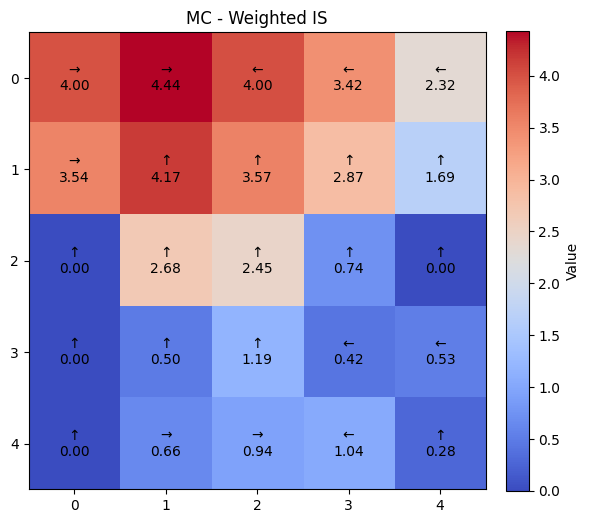

In [26]:
import numpy as np
import random
import matplotlib.pyplot as plt

# === Environment Settings ===
grid_size = 5  # Size of the grid world (5x5)
gamma = 0.95   # Discount factor
epsilon = 0.9
MAX_STEPS = 100 # Maximum steps allowed per episode
terminal_states = [(2, 0), (2, 4), (4, 0)] # Predefined terminal states
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)] #actions: Up, Down, Left, Right
action_to_idx = {a: i for i, a in enumerate(actions)}
# Define special states
def step(state, action):
    blue = (0, 1)
    green = (0, 4)
    red = (4, 2)
    yellow = (4, 4)

    # Terminal state: no change, reward 0, done = True
    if state in terminal_states:
        return state, 0, True
    if state == blue: # Blue : teleport to red with +5 reward
        return red, 5, False
    if state == green:  # Green : random teleport to red or yellow with +2.5 reward
        next_state = random.choice([red, yellow])
        return next_state, 2.5, False
     # Normal move
    r, c = state
    dr, dc = action
    nr, nc = r + dr, c + dc
    # If move goes out of bounds: stay, small penalty
    if not (0 <= nr < grid_size and 0 <= nc < grid_size):
        return state, -0.5, False

    next_state = (nr, nc)
    # If landed on terminal: return it, reward 0, done = True
    if next_state in terminal_states:
        return next_state, 0, True

    return next_state, -0.2, False

def mc_off_policy_weighted_is(num_episodes=20000, epsilon=0.1):
    Q = np.zeros((grid_size, grid_size, len(actions))) # Initialize action-value
    C = np.zeros((grid_size, grid_size, len(actions)))  # Cumulative weight
    target_policy = np.ones((grid_size, grid_size, len(actions))) / len(actions) # Init uniform π

    for ep in range(num_episodes):
        # Start from a non-terminal state
        while True:
            s = (random.randint(0, grid_size - 1), random.randint(0, grid_size - 1))
            if s not in terminal_states:
                break

        episode = []
        state = s
        t, done = 0, False
        while not done and t < MAX_STEPS:
            action = random.choice(actions)  # random behavior policy = uniform random
            next_state, reward, done = step(state, action)
            episode.append((state, action, reward))  # Store (s, a, r)
            state = next_state
            t += 1
        # Initialize return and importance weight
        G = 0
        W = 1.0
        # Process episode in reverse for WIS update
        for state, action, reward in reversed(episode):
            i, j = state
            a_idx = action_to_idx[action]
            G = gamma * G + reward  # Compute return
            # Update cumulative weight and Q-value estimate
            C[i, j, a_idx] += W
            Q[i, j, a_idx] += (W / C[i, j, a_idx]) * (G - Q[i, j, a_idx])

            # Update target policy to ε-greedy
            best_a = np.argmax(Q[i, j]) # Best action according to current Q
            for a in range(len(actions)):
                if a == best_a:
                    target_policy[i, j, a] = 1 - epsilon + epsilon / len(actions)
                else:
                    target_policy[i, j, a] = epsilon / len(actions)
            # Compute importance sampling ratio π(a|s) / b(a|s)
            pi_a = target_policy[i, j, a_idx]  # Prob. of action under target policy
            b_a = 1.0 / len(actions)  # Prob. of action under behavior policy (uniform)
            W *= pi_a / b_a   # Multiply importance weight
            if W == 0:
                break  # terminate early if weight drops to 0

    return target_policy, Q

def plot_policy_and_values(policy, Q, title=""):
    arrows = ['↑', '↓', '←', '→']
    V = np.max(Q, axis=2)  # State-value function from Q

    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(V, cmap='coolwarm', interpolation='nearest')

    ax.set_xticks(np.arange(grid_size))
    ax.set_yticks(np.arange(grid_size))
    ax.set_xticklabels([str(i) for i in range(grid_size)])
    ax.set_yticklabels([str(i) for i in range(grid_size)])

    for i in range(grid_size):
        for j in range(grid_size):
            best_action = np.argmax(policy[i, j])
            arrow = arrows[best_action]
            value = f"{V[i, j]:.2f}"
            ax.text(j, i, f"{arrow}\n{value}", ha='center', va='center', color='black', fontsize=10)

    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Value')
    plt.grid(False)
    plt.tight_layout()
    plt.show()




plot_policy_and_values(policy_wis, Q_wis, title="MC - Weighted IS")

